In [151]:
from PIL import Image,ImageDraw
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import warnings
from scipy.interpolate import spline
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from generator import dataset_generator, showImagesHorizontally
%matplotlib inline

### Generate data

In [9]:
data = dataset_generator(10000)
x_train = data[0]
y_train = data[1]

In [10]:
train_array = []
for el in x_train:
    train_array.append(np.asarray(el))
train_array = np.asarray(train_array)/255. #scaling images
y_train = np.asarray(y_train)
y_train = y_train.reshape(10000,1)

In [11]:
#remove 4'th channel
train_array = train_array[:,:,:,:3]

In [12]:
print(train_array.shape)
print(y_train.shape)

(10000, 128, 128, 3)
(10000, 1)


## Model

In [58]:
X = tf.placeholder(tf.float32, shape=[None,128,128,3])
Y = tf.placeholder(tf.float32, shape=[None,1])

#convolution + pooling
conv1 = tf.layers.conv2d(inputs=X, filters=8, kernel_size=[3,3], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=[3,3],padding="same",activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#fully-connected
flattened = tf.contrib.layers.flatten(pool2)

#w1 = tf.Variable(tf.random_normal(shape=[4096,1])) 
#b1 = tf.Variable(tf.zeros(shape = [1]))
#out = tf.add(tf.matmul(flattened,w1),b1)
out = tf.contrib.layers.fully_connected(inputs = flattened, num_outputs = 1, activation_fn=None)

loss = tf.losses.mean_squared_error(labels=Y, predictions=out)
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

In [100]:
training_epochs = 10000

In [101]:
#Инициализация
init = tf.global_variables_initializer()
#Обучение
sss = tf.Session()
sss.run(init)
loss_list = []
epoch_number = []
for epoch in range(1, training_epochs+1):
    permutation=np.random.permutation(10000)
    permutation=permutation[0:64]
    batch=[train_array[permutation], y_train[permutation]]
    if epoch % 500 == 0:
        epoch_number.append(epoch)
        epoch_loss = []
        for _ in range(1000):
            test_permutation=np.random.permutation(10000)
            test_permutation=permutation[0:64]
            lossa = sss.run(loss, feed_dict={X:batch[0], Y: batch[1]})
            epoch_loss.append(lossa)
        print(np.array(epoch_loss).mean())
        loss_list.append(np.array(epoch_loss).mean())
    #print(sss.run(loss, feed_dict={X:batch[0], Y: batch[1]}))
        
    sss.run(train_step, feed_dict={X:batch[0], Y: batch[1]})

print("Optimization Finished!")

0.135646
0.104591
0.0863983
0.0283383
0.0804661
0.0406848
0.0577179
0.0345418
0.0257061
0.0289287
0.0355558
0.025142
0.0261907
0.0298209
0.0148842
0.0452854
0.0203467
0.0128275
0.0353428
0.0210533
Optimization Finished!


### Loss function plot

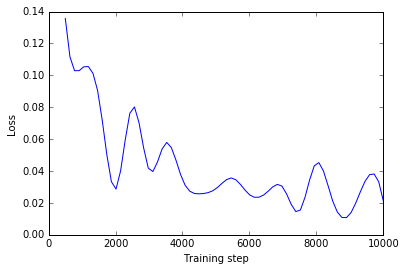

In [158]:
x = np.array(epoch_number)
xnew = np.linspace(x.min(),x.max(),70)
power_smooth = spline(x,loss_list,xnew)
plt.plot(xnew,power_smooth)
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.show()

### Test

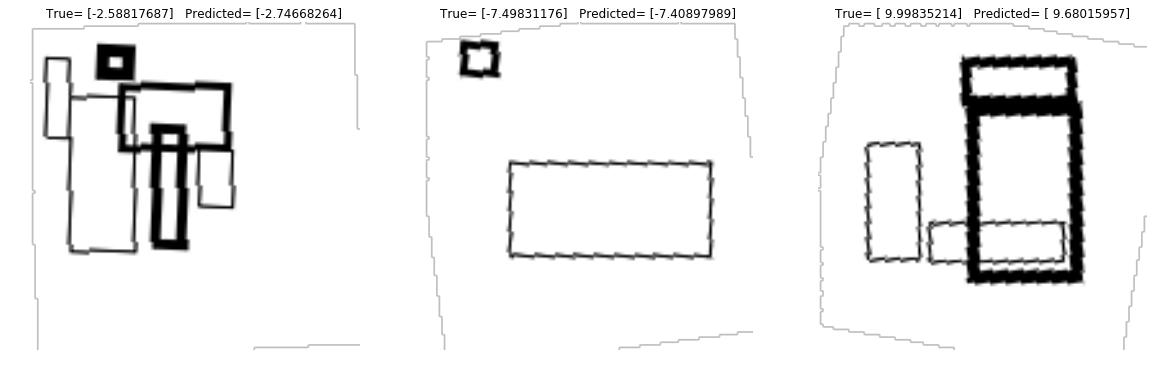

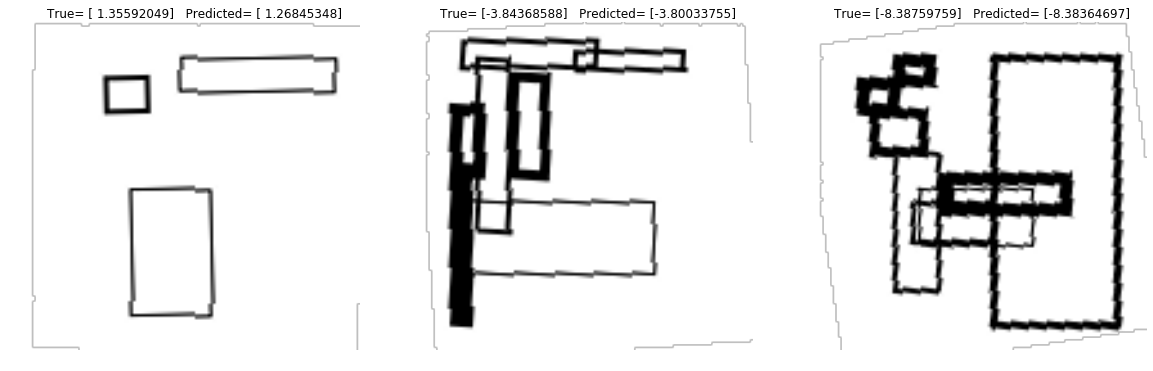

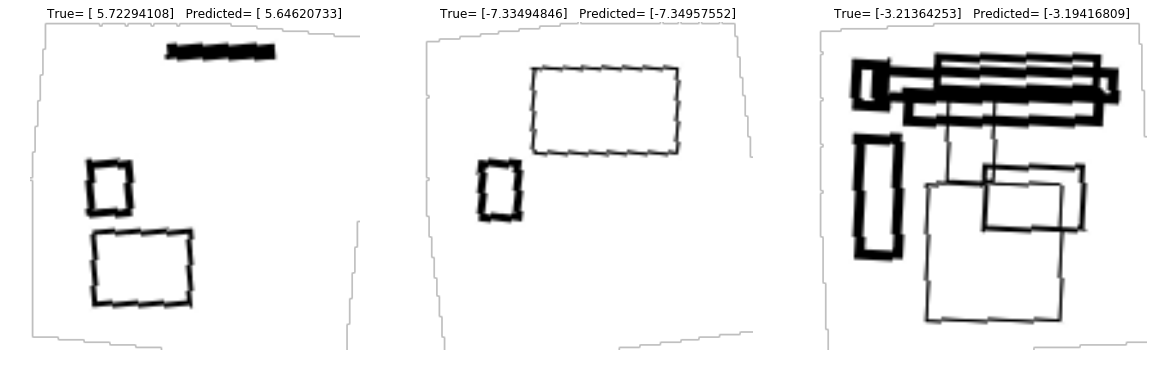

In [203]:
for i in range(3):
    data_test = dataset_generator(3) # generate test objects
    x_test = data_test[0]  # images
    y_test = data_test[1]  # angle values
    test_array = []
    for el in x_test:
        test_array.append(np.asarray(el))
    test_array = np.asarray(test_array)/255.
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(3,1)
    test_array = test_array[:,:,:,:3]
    predicted = sss.run(out, feed_dict={X:test_array})
    showImagesHorizontally(x_test)